---
# Dataset Scaling
---

In [3]:
import cudf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. Load Data with cuDF and Convert to Pandas
# ---------------------------
train_df = cudf.read_csv("susy_train.csv")
test_df  = cudf.read_csv("susy_test.csv")

train_pd = train_df.to_pandas()
test_pd  = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("class_label")
target_column   = "class_label"

# ---------------------------
# 2. Split Training Data (80-20 split for training and validation)
# ---------------------------
train_data, val_data = train_test_split(
    train_pd, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_pd[target_column]
)

# ---------------------------
# 3. Scale Features using StandardScaler
# ---------------------------
scaler = StandardScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
val_data[feature_columns]   = scaler.transform(val_data[feature_columns])
test_pd[feature_columns]    = scaler.transform(test_pd[feature_columns])

# ---------------------------
# 4. Save Scaled Datasets to CSV Files
# ---------------------------
train_data.to_csv("susy_train_scaled.csv", index=False)
val_data.to_csv("susy_val_scaled.csv", index=False)
test_pd.to_csv("susy_test_scaled.csv", index=False)

print("Scaled datasets saved as 'susy_train_scaled.csv', 'susy_val_scaled.csv', and 'susy_test_scaled.csv'.")


Scaled datasets saved as 'susy_train_scaled.csv', 'susy_val_scaled.csv', and 'susy_test_scaled.csv'.


Dataset Shapes:
  Training set shape: (2666666, 19)
  Validation set shape: (666667, 19)
  Test set shape: (1666667, 19)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Epoch 1/1000: Train Loss: 0.4314 | Train Acc: 80.11% || Val Loss: 0.4294 | Val Acc: 80.30% | Val ROC AUC: 0.8753 || LR: 0.001000 | Time: 115.40 sec
--> New best model saved with Val ROC AUC: 0.8753
Epoch 2/1000: Train Loss: 0.4275 | Train Acc: 80.30% || Val Loss: 0.4275 | Val Acc: 80.32% | Val ROC AUC: 0.8758 || LR: 0.001000 | Time: 117.73 sec
--> New best model saved with Val ROC AUC: 0.8758
Epoch 3/1000: Train Loss: 0.4264 | Train Acc: 80.33% || Val Loss: 0.4267 | Val Acc: 80.32% | Val ROC AUC: 0.8760 || LR: 0.001000 | Time: 116.48 sec
--> New best model saved with Val ROC AUC: 0.8760
Epoch 4/1000: Train Loss: 0.4259 | Train Acc: 80.35% || Val Loss: 0.4264 | Val Acc: 80.28% | Val ROC AUC: 0.8763 || LR: 0.001000 | Time: 117.65 sec
--> New best model saved with Val ROC AUC: 0.8763
Epoch 5/1000: Train Loss: 0.4

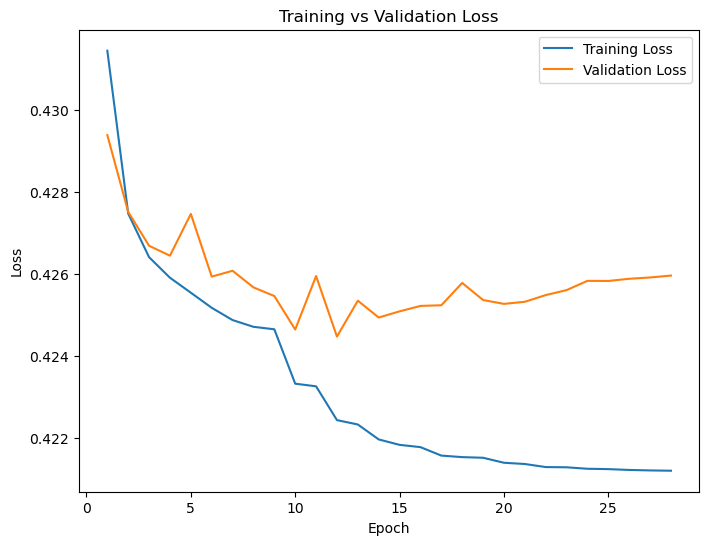

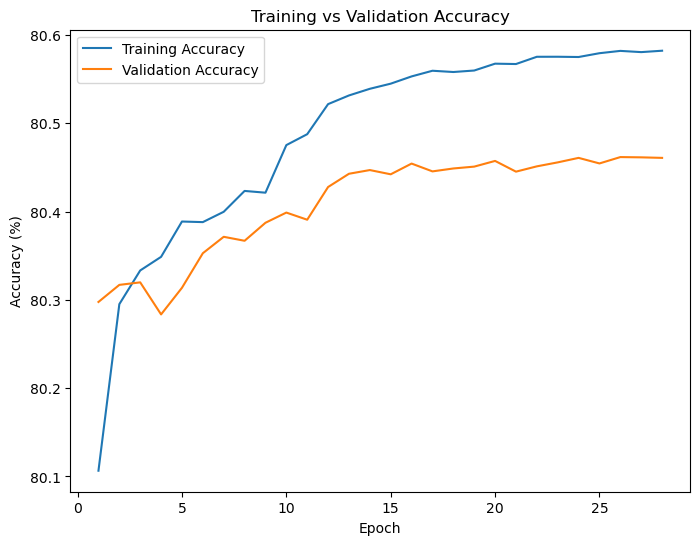

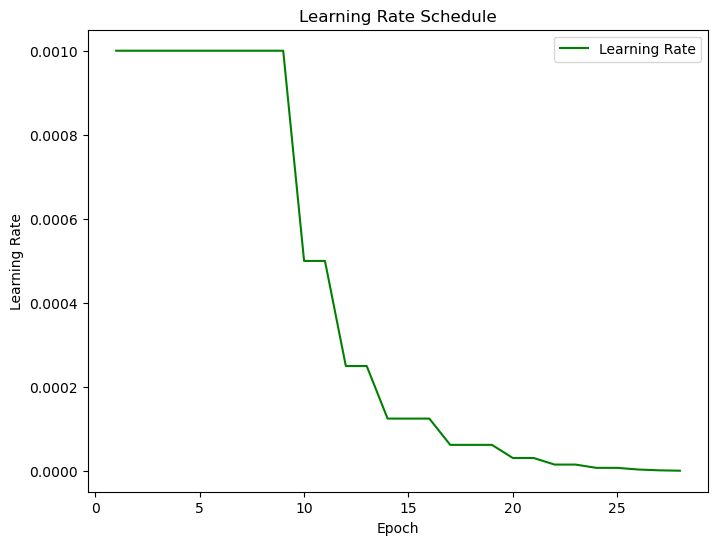


Test Set Evaluation:
  Test Loss: 0.4242
  Test Accuracy: 80.47%

Classification Report:
              precision    recall  f1-score   support

           0     0.7880    0.8754    0.8294    903599
           1     0.8301    0.7211    0.7718    763068

    accuracy                         0.8047   1666667
   macro avg     0.8091    0.7982    0.8006   1666667
weighted avg     0.8073    0.8047    0.8030   1666667



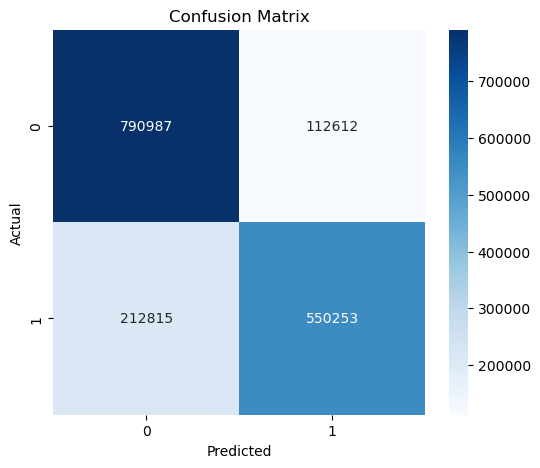

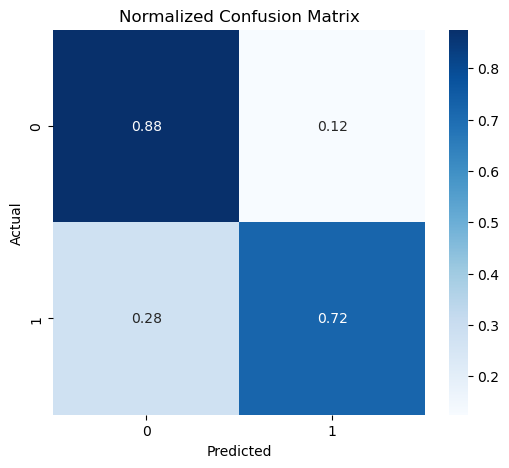

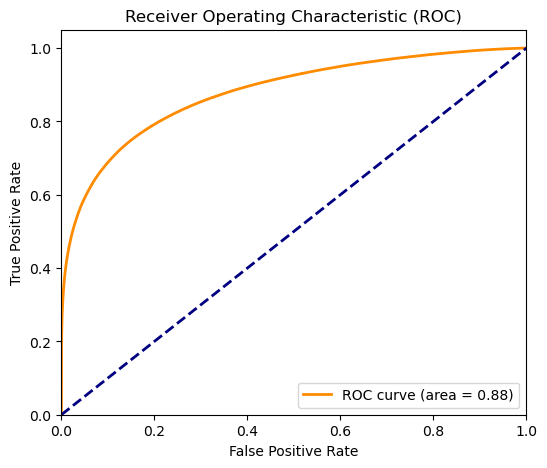

ROC AUC Score: 0.8781
CPU times: user 48min 25s, sys: 8min 27s, total: 56min 53s
Wall time: 55min 54s


In [2]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ---------------------------
# 1. Load Scaled Datasets from CSV
# ---------------------------
train_pd = pd.read_csv("susy_train_scaled.csv")
val_pd   = pd.read_csv("susy_val_scaled.csv")
test_pd  = pd.read_csv("susy_test_scaled.csv")

feature_columns = train_pd.columns.drop("class_label")
target_column   = "class_label"


# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_pd.shape)
print("  Validation set shape:", val_pd.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create Custom PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects
train_dataset = CustomDataset(train_pd, feature_columns, target_column)
val_dataset   = CustomDataset(val_pd, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network Architecture
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim4),
            nn.ReLU(),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.ReLU(),
            nn.Linear(hidden_dim5, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim1 = 176      
hidden_dim2 = 128      
hidden_dim3 = 128      
hidden_dim4 = 128      
hidden_dim5 = 160      
output_dim = 2        # binary classification (two classes)

# model = NeuralNet(input_dim, hidden_dim, output_dim)
model = NeuralNet(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

# ---------------------------
# 4. Setup Device and Optimizations
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

criterion   = nn.CrossEntropyLoss()
initial_lr  = 0.001
min_lr      = 1e-6
optimizer   = optim.Adam(model.parameters(), lr=initial_lr)

# ---------------------------
# 5. Training Loop with Dynamic Learning Rate Reduction
# ---------------------------
num_epochs = 1000
best_val_roc_auc = 0.0

# Lists for storing metrics for plotting
train_losses    = []
val_losses      = []
train_accuracies= []
val_accuracies  = []
lrs             = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Training step
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_probs  = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            val_probs.extend(probs.detach().cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = float('nan')
    
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    lrs.append(current_lr)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val ROC AUC: {val_roc_auc:.4f} || "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f} sec")
    
    # Adjust learning rate if no improvement
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(model.state_dict(), "susy_best_model_144.pth")
        print(f"--> New best model saved with Val ROC AUC: {best_val_roc_auc:.4f}")
    else:
        if current_lr > min_lr:
            new_lr = max(current_lr * 0.5, min_lr)
            optimizer.param_groups[0]['lr'] = new_lr
            print(f"--> No improvement, reducing learning rate to {new_lr:.6f}")
        else:
            print("Learning rate is at minimum and no improvement observed. Stopping training.")
            break

# ---------------------------
# 6. Plotting Metrics
# ---------------------------
epochs_range = range(1, len(train_losses) + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Learning Rate Schedule
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# ---------------------------
# 7. Load Best Model and Evaluate on Test Set
# ---------------------------
model.load_state_dict(torch.load("susy_best_model_144.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probabilities for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probs.detach().cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report and Confusion Matrix
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 9. ROC Curve and ROC AUC Score
# ---------------------------
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
